In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

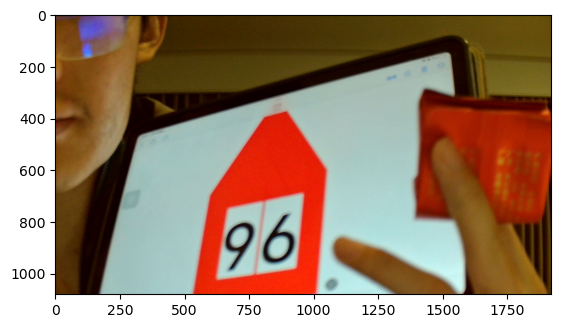

In [49]:
img = cv2.imread('images_for_calibration/1674048759.2812796.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

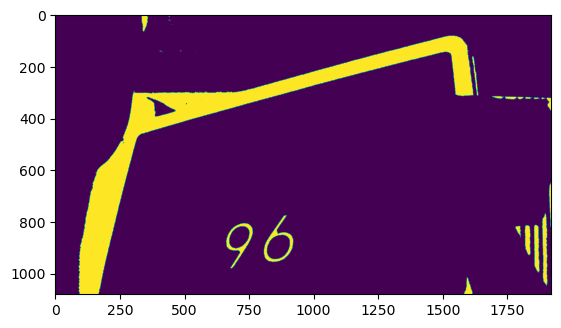

In [50]:
# mask out colored area, only keep the black and gray area
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 255, 50])
mask = cv2.inRange(hsv, lower_black, upper_black)
plt.imshow(mask)

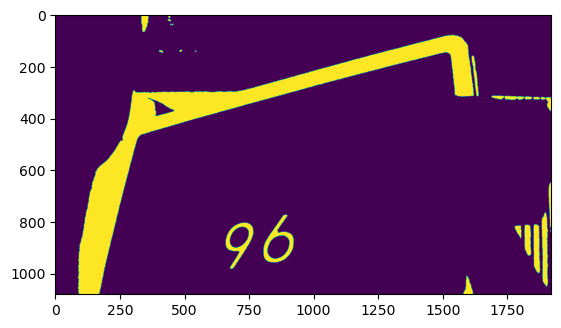

In [51]:
# dilate the mask to fill in the holes
kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
plt.imshow(mask)

179181.0
12068.0
9991.5
5792.5
5104.0
4379.5
3703.5
2591.5


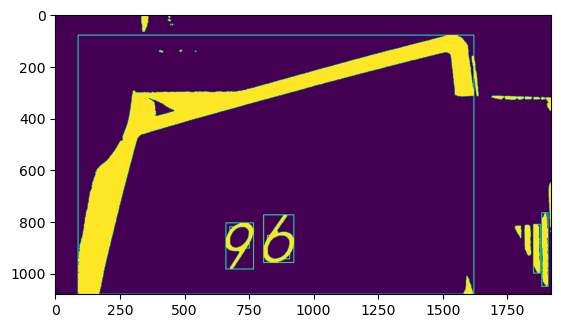

In [52]:
# find digit area
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
mask_cp = mask.copy()
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 50**2:
        print(area)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(mask_cp, (x, y), (x + w, y + h), (255, 255, 255), 2)
plt.imshow(mask_cp)

179181.0
12068.0
9991.5
5792.5
5104.0
4379.5
3703.5
2591.5


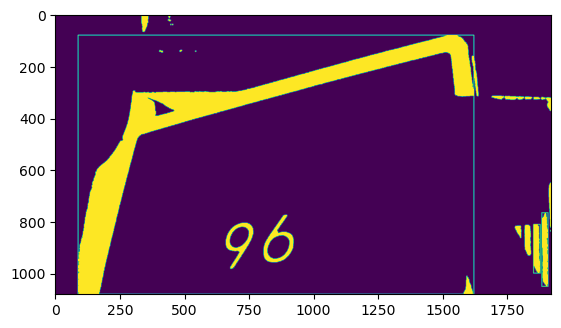

In [53]:
# apply NMS to remove overlapping bounding boxes
def nms(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
    return boxes[pick].astype("int")

# find digit area
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
mask_cp = mask.copy()
boxes = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 50**2:
        print(area)
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x + w, y + h])
boxes = np.array(boxes)
boxes = nms(boxes, 0.3)
for box in boxes:
    x, y, x2, y2 = box
    cv2.rectangle(mask_cp, (x, y), (x2, y2), (255, 255, 255), 2)

plt.imshow(mask_cp)